# Preparation

### Colab specific prep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pyunpack patool

     |████████████████████████████████| 77 kB 5.5 MB/s 


In [ ]:
from pyunpack import Archive
Archive('/content/drive/My Drive/CSGODATA/mlready2.rar').extractall('/content/')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


### Preparation (non-colab)

In [1]:
import os
import pandas as pd
import tensorflow as tf
import datetime
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

In [2]:
current_dt = datetime.datetime.now()
timestamp_str = current_dt.strftime("%Y%m%d-%H%M")

In [3]:
def reshape_dataframe(df, target_col):
    X_data = df.drop(target_col, axis=1).to_numpy()
    num_features = int(X_data.shape[1] / WINDOW_LENGTH)
    X_data = X_data.reshape(X_data.shape[0], WINDOW_LENGTH, num_features)
    y_data = df[target_col].to_numpy()
    return X_data, y_data


def train_model_on_rounds(model, epochs, path_train_data, class_weights=None):
    train_matches = os.listdir(path_train_data) 
    
    for i in range(epochs):
        
        for match in train_matches:
            print(match)
            path_match = os.path.join(path_train_data, match)
            rounds = os.listdir(path_match)

            for r in rounds:
                path_round = os.path.join(path_match, r)
                files = os.listdir(path_round)

                for file in files:
                    fullfile = os.path.join(path_round, file)
                    df = pd.read_parquet(fullfile)
                    target_col = f"forecast_dead-{STEPS_FORECAST}"
                    X, y = reshape_dataframe(df, target_col)

                    loss, acc = model.train_on_batch(X, y, class_weight=class_weights)
        #print(f'epoch {i:2d} loss {loss:=5.3f}, acc {acc:=6.2%}')

    return model

def test_model_on_rounds(model, path_test_data):
    test_matches = os.listdir(path_test_data)
    y_pred = []
    y_test = []
    
    for match in test_matches:
        path_match = os.path.join(path_test_data, match)
        rounds = os.listdir(path_match)

        for r in rounds:
            path_round = os.path.join(path_match, r)
            files = os.listdir(path_round)

            for file in files:
                fullfile = os.path.join(path_round, file)
                df = pd.read_parquet(fullfile)
                target_col = f"forecast_dead-{STEPS_FORECAST}"
                X, y = reshape_dataframe(df, target_col)

                y_test.append(y)
                y_pred.append(model.predict_on_batch(X))
    
    return np.concatenate(y_test, axis=0), np.concatenate(y_pred, axis=0)

In [4]:
WINDOW_LENGTH = 5
STEPS_FORECAST = 3
class_weights = {0:0.5, 1:2}
path_models = r"E:\Thesis code and data\csgo-ml-master\models"

In [5]:
path_mlready_data = r"E:\Thesis code and data\csgo-ml-master\data\mlready3"
folder = f"winSize-{WINDOW_LENGTH}_forecSteps-{STEPS_FORECAST}"
path_train_data = os.path.join(path_mlready_data, folder, 'train')
path_val_data = os.path.join(path_mlready_data, folder, 'val')
path_test_data = os.path.join(path_mlready_data, folder, 'test')

In [6]:
# get the number of features for that dataset
match = os.listdir(path_train_data)[0]
r = os.listdir(os.path.join(path_train_data, match))[0]
filepath = os.path.join(path_train_data, match, r)
file = os.listdir(filepath)[0]
fullfile = os.path.join(filepath, file)

df = pd.read_parquet(fullfile)
for col in df.columns:
    print(col)

target_col = f"forecast_dead-{STEPS_FORECAST}"
X, y = reshape_dataframe(df, target_col)
num_features = X.shape[2]
print(num_features)

hp (t-4)
armor (t-4)
isBlinded (t-4)
isAirborne (t-4)
isDucking (t-4)
isStanding (t-4)
isScoped (t-4)
isWalking (t-4)
equipmentValue (t-4)
cash (t-4)
hasHelmet (t-4)
kills_from_avg (t-4)
deaths_from_avg (t-4)
total_hp_enemy (t-4)
total_hp_team (t-4)
num_enemy_alive (t-4)
num_team_alive (t-4)
enemy_in_range_200 (t-4)
enemy_in_range_500 (t-4)
enemy_in_range_1000 (t-4)
enemy_in_range_2000 (t-4)
enemy_hp_in_range_500 (t-4)
enemy_hp_in_range_1000 (t-4)
enemy_hp_in_range_2000 (t-4)
enemy_equipment_in_range_500 (t-4)
enemy_equipment_in_range_1000 (t-4)
enemy_equipment_in_range_2000 (t-4)
team_in_range_200 (t-4)
team_in_range_500 (t-4)
team_in_range_1000 (t-4)
equipment_value_team (t-4)
equipment_value_enemy (t-4)
distance_closest_enemy (t-4)
hp_closest_enemy (t-4)
active_weapon_Melee Kills (t-4)
active_weapon_Pistol Kills (t-4)
active_weapon_Shotgun Kills (t-4)
active_weapon_SMG Kills (t-4)
active_weapon_Assault Rifle Kills (t-4)
active_weapon_Machine Gun Kills (t-4)
active_weapon_Sniper Rifl

In [7]:
# Class weight explanation
# I calculated the weights from one class for several matches. 0 was always
# about 0.5, 1 ranged from 2 to 40. I tested values 2, 5, 10, 20 and 40
# in models trained for 1 epoch and the {0:05, 1:2} classweights performed best
# on f1
"""
match = os.listdir(path_train_data)[0]
rounds = os.listdir(os.path.join(path_train_data, match))
y_list = []
for r in rounds:
    filepath = os.path.join(path_train_data, match, r)
    files = os.listdir(filepath)
    for file in files:
        fullfile = os.path.join(filepath, file)

        df = pd.read_parquet(fullfile)
        target_col = f"forecast_dead-{STEPS_FORECAST}"
        X, y = reshape_dataframe(df, target_col)
        y_list.append(y)
y = np.concatenate(y_list)

cw = compute_class_weight('balanced', classes=np.unique(y), y=y)
cw[1] = cw[1]/3  
class_weights = {0:cw[0], 1:cw[1]}
#class_weights = {0:0.5, 1:2}
#class_weights
"""
class_weights = {0:0.5, 1:2}

# Conv1D

In [ ]:
model_Conv1D = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=WINDOW_LENGTH, activation='relu', padding='causal',  input_shape=(WINDOW_LENGTH, num_features)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=WINDOW_LENGTH, activation='relu', padding='causal'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_Conv1D.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_Conv1D = train_model_on_rounds(model_Conv1D,
  epochs=5, path_train_data=path_train_data, class_weights=class_weights)

atk-vs-rbg-m2-nuke
fiend-vs-dignitas-m2-mirage
bco-vs-indinda-mirage
esuba-vs-extremum-fire-m2-vertigo
nlg-vs-sj-m1-inferno
og-vs-nip-m3-dust2
third-impact-vs-ggpr-m2-overpass
wings-up-vs-checkmate-m3-nuke
lol123-vs-camo-ancient
havan-liberty-vs-sws-nuke
finest-vs-inde-irae-m1-mirage
checkmate-vs-lynn-vision-inferno
bad-news-bears-vs-rbg-m3-overpass
skade-vs-anonymo-m2-inferno
blink-vs-lyngby-vikings-m3-overpass
strife-vs-onet4p-m1-vertigo
tricked-vs-ec-kyiv-m3-vertigo
river-plate-vs-coscu-army-m2-nuke
777-vs-ec-kyiv-m1-dust2
lyngby-vikings-vs-astralis-talent-m1-inferno
inde-irae-vs-ec-kyiv-m3-ancient
party-astronauts-vs-na-s-finest-m3-inferno
nkt-vs-catevil-m1-mirage
order-vs-lookingfororg-m2-dust2
ceara-vs-havan-liberty-m2-overpass
faze-vs-dignitas-m1-mirage
nom-vs-nexus-mirage
spirit-academy-vs-south-m1-nuke
endpoint-vs-wisla-krakow-m3-ancient
detona-vs-leviatan-overpass
1win-vs-sinners-m1-nuke
finest-vs-kova-m3-mirage
lyngby-vikings-vs-tricked-m1-overpass
detona-vs-rehl-overpass
th

In [ ]:
y_test_Conv1D, y_pred_p_Conv1D = test_model_on_rounds(model_Conv1D, path_val_data)
y_pred_Conv1D = (y_pred_p_Conv1D>0.5)
report = classification_report(y_test_Conv1D, y_pred_Conv1D)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99   2601922
         1.0       0.42      0.33      0.37     64548

    accuracy                           0.97   2666470
   macro avg       0.70      0.66      0.68   2666470
weighted avg       0.97      0.97      0.97   2666470



In [ ]:
filename = f"model_wl{WINDOW_LENGTH}_nf{num_features}_sf{STEPS_FORECAST}_Conv1D_FINAL{timestamp_str}"
print(filename)
model_Conv1D.save(os.path.join(path_models, filename))

model_wl5_nf50_sf3_Conv1D_FINAL20211202-0219
INFO:tensorflow:Assets written to: /content/drive/My Drive/CSGODATA/models/model_wl5_nf50_sf3_Conv1D_FINAL20211202-0219/assets


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model_Conv1D, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


# RNN

In [ ]:
model_RNN = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(128, activation='relu', input_shape=(WINDOW_LENGTH, num_features), return_sequences=True),
    tf.keras.layers.SimpleRNN(128, activation='relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_RNN = train_model_on_rounds(model_RNN,
  epochs=5, path_train_data=path_train_data, class_weights=class_weights)

mousesports-vs-nip-m3-inferno
trasko-vs-ec-kyiv-m2-ancient
teamone-vs-mythic-m2-inferno
lyngby-vikings-vs-entropiq-m2-dust2
ldlc-vs-wisla-krakow-m1-ancient
bluejays-vs-ago-m1-mirage
9z-vs-river-plate-m2-nuke
lyngby-vikings-vs-young-ninjas-m2-overpass
ground-zero-vs-rooster-nuke
rooster-vs-lol123-m1-nuke
third-impact-vs-verum-m1-inferno
indinda-vs-checkmate-m1-dust2
extremum-vs-dignitas-m2-mirage
coalesce-vs-bluejays-m2-vertigo
freedom-fighters-vs-levitate-m2-nuke
third-impact-vs-coldest-riders-m3-nuke
endpoint-vs-wisla-krakow-m1-inferno
natus-vincere-vs-ence-m2-nuke
nkt-vs-wings-up-m2-inferno
mad-lions-vs-ec-kyiv-m2-mirage
skade-vs-wisla-krakow-m2-overpass
blink-vs-oilers-m2-overpass
gambit-vs-vitality-m2-vertigo
touch-point-vs-clg-red-m1-nuke
bebra-vs-peakyblinders-m3-mirage
strife-vs-onet4p-m2-nuke
alhilal-vs-alnasser-m2-mirage
meta4pro-vs-bluejays-m1-dust2
blink-vs-esuba-m2-vertigo
skade-vs-anonymo-m2-inferno
big-chillin-vs-coldest-riders-m2-dust2
anonymo-vs-gamerlegion-m2-vertigo
h

In [ ]:
y_test_RNN, y_pred_p_RNN = test_model_on_rounds(model_RNN, path_val_data)
y_pred_RNN = (y_pred_p_RNN>0.5)
report = classification_report(y_test_RNN, y_pred_RNN)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99   2601922
         1.0       0.54      0.27      0.36     64548

    accuracy                           0.98   2666470
   macro avg       0.76      0.63      0.67   2666470
weighted avg       0.97      0.98      0.97   2666470



In [ ]:
filename = f"model_wl{WINDOW_LENGTH}_nf{num_features}_sf{STEPS_FORECAST}_RNN_FINAL{timestamp_str}"
print(filename)
model_RNN.save(os.path.join(path_models, filename))

model_wl5_nf50_sf3_RNN_20211130-1056.pb
INFO:tensorflow:Assets written to: /content/drive/My Drive/CSGODATA/models/model_wl5_nf50_sf3_RNN_20211130-1056.pb/assets


# LSTM

In [ ]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='tanh', input_shape=(WINDOW_LENGTH, num_features), return_sequences=True),
    tf.keras.layers.LSTM(128, activation='tanh'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_LSTM = train_model_on_rounds(model_LSTM,
    epochs=5, path_train_data=path_train_data, class_weights=class_weights)

mousesports-vs-nip-m3-inferno
trasko-vs-ec-kyiv-m2-ancient
teamone-vs-mythic-m2-inferno
lyngby-vikings-vs-entropiq-m2-dust2
ldlc-vs-wisla-krakow-m1-ancient
bluejays-vs-ago-m1-mirage
9z-vs-river-plate-m2-nuke
lyngby-vikings-vs-young-ninjas-m2-overpass
ground-zero-vs-rooster-nuke
rooster-vs-lol123-m1-nuke
third-impact-vs-verum-m1-inferno
indinda-vs-checkmate-m1-dust2
extremum-vs-dignitas-m2-mirage
coalesce-vs-bluejays-m2-vertigo
freedom-fighters-vs-levitate-m2-nuke
third-impact-vs-coldest-riders-m3-nuke
endpoint-vs-wisla-krakow-m1-inferno
natus-vincere-vs-ence-m2-nuke
nkt-vs-wings-up-m2-inferno
mad-lions-vs-ec-kyiv-m2-mirage
skade-vs-wisla-krakow-m2-overpass
blink-vs-oilers-m2-overpass
gambit-vs-vitality-m2-vertigo
touch-point-vs-clg-red-m1-nuke
bebra-vs-peakyblinders-m3-mirage
strife-vs-onet4p-m2-nuke
alhilal-vs-alnasser-m2-mirage
meta4pro-vs-bluejays-m1-dust2
blink-vs-esuba-m2-vertigo
skade-vs-anonymo-m2-inferno
big-chillin-vs-coldest-riders-m2-dust2
anonymo-vs-gamerlegion-m2-vertigo
h

In [ ]:
y_test_LSTM, y_pred_p_LSTM = test_model_on_rounds(model_LSTM, path_val_data)
y_pred_LSTM = (y_pred_p_LSTM>0.5)

In [ ]:
report_LSTM = classification_report(y_test_LSTM, y_pred_LSTM)
print(report_LSTM)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99   2601922
         1.0       0.39      0.36      0.38     64548

    accuracy                           0.97   2666470
   macro avg       0.69      0.67      0.68   2666470
weighted avg       0.97      0.97      0.97   2666470



In [ ]:
filename = f"model_wl{WINDOW_LENGTH}_nf{num_features}_sf{STEPS_FORECAST}_LSTM_FINAL_{timestamp_str}"
print(filename)
model_LSTM.save(os.path.join(path_models, filename))

model_wl5_nf50_sf3_LSTM_FINAL_20211129-1937


INFO:tensorflow:Assets written to: /content/drive/My Drive/CSGODATA/models/model_wl5_nf50_sf3_LSTM_FINAL_20211129-1937/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/CSGODATA/models/model_wl5_nf50_sf3_LSTM_FINAL_20211129-1937/assets


# Best model test

### Performance on test for LSTM

In [8]:
from tensorflow import keras

final_LSTM = keras.models.load_model(r"E:\Thesis code and data\csgo-ml-master\models\model_wl5_nf50_sf3_LSTM_FINAL_20211129-1937")

In [9]:
y_test_LSTMf, y_pred_p_LSTMf = test_model_on_rounds(final_LSTM, path_test_data)
y_pred_LSTMf = (y_pred_p_LSTMf>0.5)

In [10]:
report_LSTMf = classification_report(y_test_LSTMf, y_pred_LSTMf)
print(report_LSTMf)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99   3534051
         1.0       0.39      0.36      0.38     87229

    accuracy                           0.97   3621280
   macro avg       0.69      0.67      0.68   3621280
weighted avg       0.97      0.97      0.97   3621280



Same as on validation set!

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_LSTMf, y_pred_p_LSTMf, pos_label=1)

In [46]:
roc_auc_score(y_test_LSTMf, y_pred_p_LSTMf)

0.9168098744206826

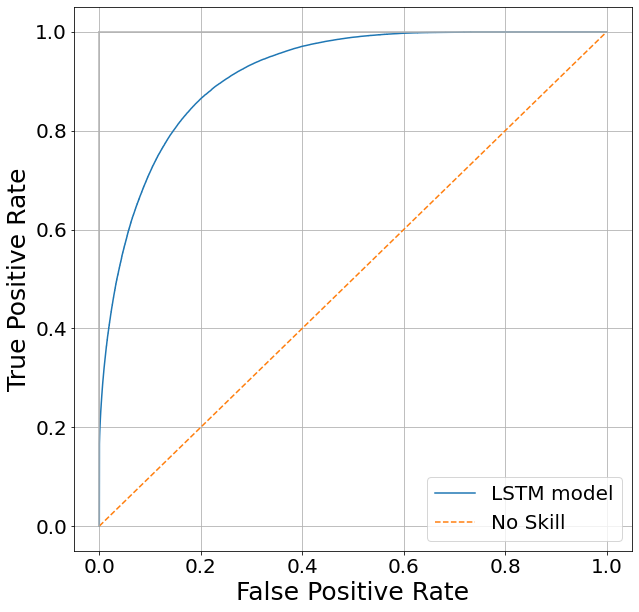

In [47]:
import matplotlib.pyplot as plt

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.subplots(1, figsize=(10,10))
#plt.title('ROC Curve for LSTM model on test data', fontsize = 30)
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate', fontsize = 25)
plt.xlabel('False Positive Rate', fontsize = 25)
plt.grid(True)
plt.legend(['LSTM model', 'No Skill'], fontsize=20)
plt.savefig('roccurve.png')
plt.show()
#plt.xticks(fontsize=20)

### Get train performance for over/underfit

In [ ]:
y_test_LSTMff, y_pred_p_LSTMff = test_model_on_rounds(final_LSTM, path_train_data)
y_pred_LSTMff = (y_pred_p_LSTMff>0.5)
report_LSTMff = classification_report(y_test_LSTMff, y_pred_LSTMff)
print(report_LSTMff)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99  12052369
         1.0       0.39      0.37      0.38    296245

    accuracy                           0.97  12348614
   macro avg       0.69      0.68      0.68  12348614
weighted avg       0.97      0.97      0.97  12348614



On train data, same performance - so no over/underfit